In [1]:
import tensorflow

In [2]:
from tensorflow.keras import optimizers, losses

In [3]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from tensorflow.keras.preprocessing import sequence

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [6]:
class Visualization:
    labels = ['Normal', 'Anomaly']
    
    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.figure(figsize=(10, 8))
            plt.plot(error, marker = 'o', ms = 3.5, linestyle = '', label = 'Point')
            
            plt.hlines(threshold, xmin=0, xmax=len(error) - 1, colors='r', zorder=100, label='Threshold')
            plt.legend()
            plt.title('Reconstruction Error')
            plt.ylabel('Error')
            plt.xlabel('Data')
            plt.show()

In [7]:
dataFilePaths = ['data/art_daily_no_noise.csv',
                 'data/art_daily_nojump.csv',
                 'data/art_daily_jumpsdown.csv',
                 'data/art_daily_perfect_square_wave.csv',
                 'data/art_increase_spike_density.csv',
                 'data/art_load_balancer_spikes.csv',
                 'data/ambient_temperature_system_failure.csv',
                 'data/nyc_taxi.csv',
                 'data/ec2_cpu_utilization.csv',
                 'data/rds_cpu_utilization.csv']

In [8]:
i = 7

dataFilePath = dataFilePaths[i]
dataFilePath

'data/nyc_taxi.csv'

In [9]:
df= pd.read_csv(filepath_or_buffer=dataFilePath, header=0, sep=',')
print('Shape:', df.shape[0])
print('Head:')
print(df.head(5))

Shape: 10320
Head:
             timestamp  value
0  2014-07-01 00:00:00  10844
1  2014-07-01 00:30:00   8127
2  2014-07-01 01:00:00   6210
3  2014-07-01 01:30:00   4656
4  2014-07-01 02:00:00   3820


In [10]:
df['Datetime'] = pd.to_datetime(df['timestamp'])
# timestamp 형태의 자료를 시계열 형태의 자료로 바꿈
print(df.head())

             timestamp  value            Datetime
0  2014-07-01 00:00:00  10844 2014-07-01 00:00:00
1  2014-07-01 00:30:00   8127 2014-07-01 00:30:00
2  2014-07-01 01:00:00   6210 2014-07-01 01:00:00
3  2014-07-01 01:30:00   4656 2014-07-01 01:30:00
4  2014-07-01 02:00:00   3820 2014-07-01 02:00:00


In [11]:
df.shape

(10320, 3)

Text(0.5, 1.0, 'Time Series of value by date time')

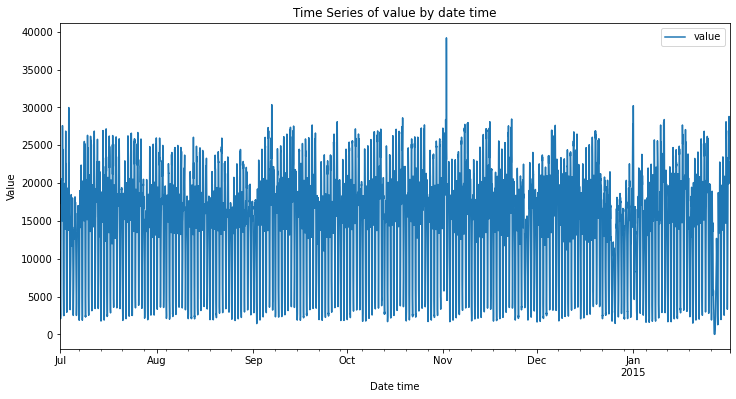

In [12]:
df.plot(x='Datetime', y = 'value', figsize = (12, 6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

In [13]:
df.value.describe()

count    10320.000000
mean     15137.569380
std       6939.495808
min          8.000000
25%      10262.000000
50%      16778.000000
75%      19838.750000
max      39197.000000
Name: value, dtype: float64

<AxesSubplot:title={'center':'Before Scaling'}, xlabel='value', ylabel='Density'>

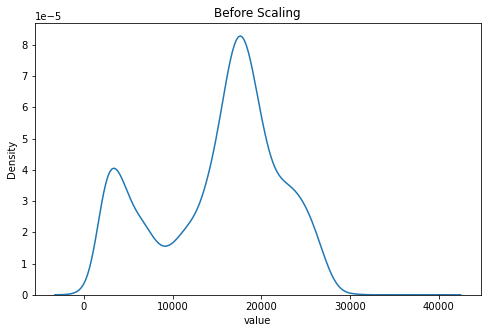

In [14]:
fig, (ax1) = plt.subplots(ncols=1, figsize = (8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])), columns=['value'])
print('Shape:', df.shape[0])
df.head()

Shape: 10320


,timestamp,value,Datetime,scaled_value
0,2014-07-01 00:00:00,10844,2014-07-01 00:00:00,0.276506
1,2014-07-01 00:30:00,8127,2014-07-01 00:30:00,0.207175
2,2014-07-01 01:00:00,6210,2014-07-01 01:00:00,0.158259
3,2014-07-01 01:30:00,4656,2014-07-01 01:30:00,0.118605
4,2014-07-01 02:00:00,3820,2014-07-01 02:00:00,0.097272


<AxesSubplot:title={'center':'After Scaling'}, xlabel='scaled_value', ylabel='Density'>

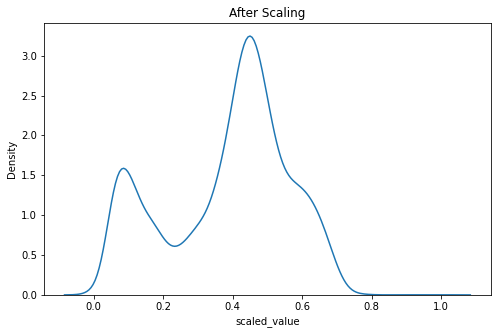

In [16]:
fig, (ax1) = plt.subplots(ncols=1, figsize = (8,5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

x축의 간격이 40000에서 1로 줄어들었다.

In [17]:
time_steps = 48
# 30분 단위로 데이터를 기록 하였으므로, 24시간 단위의 학습을 위해선 48로 지정.
metric = 'mean_absolute_error'

In [18]:
model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape = (time_steps, 1), return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss = 'mean_absolute_error', metrics=[metric])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48, 32)            4352      
                                                                 
 dense (Dense)               (None, 48, 1)             33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


시계열 형태의 전처리

In [20]:
sequence = np.array(df['scaled_value'])
print(sequence)

[0.27650616 0.20717548 0.1582587  ... 0.69664957 0.6783281  0.67059634]


In [21]:
samples = len(sequence)
# 전체 데이터의 개수
trim = samples % time_steps
# 몫의 개수 설정
subsequences = int(samples/time_steps)
# 전체 sequence 에서 subsequence 의 개수 구하기
sequence_trimmed = sequence[:samples - trim]

In [22]:
print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
# 3차원 배열 형태로 조정
print(sequence_trimmed.shape)

10320 215
(215, 48, 1)


In [23]:
training_dataset = sequence_trimmed
print('training_dataset:', training_dataset.shape)

training_dataset: (215, 48, 1)


In [24]:
batch_size = 32
epochs = 20

In [25]:
model.fit(x=training_dataset, y=training_dataset, batch_size=batch_size,
         epochs=epochs, validation_data=(training_dataset, training_dataset))

Epoch 1/20
7/7 [==============================] - 2s 101ms/step - loss: 0.1578 - mean_absolute_error: 0.1578 - val_loss: 0.1518 - val_mean_absolute_error: 0.1518
Epoch 2/20
7/7 [==============================] - 0s 41ms/step - loss: 0.1493 - mean_absolute_error: 0.1493 - val_loss: 0.1481 - val_mean_absolute_error: 0.1481
Epoch 3/20
7/7 [==============================] - 0s 49ms/step - loss: 0.1478 - mean_absolute_error: 0.1478 - val_loss: 0.1465 - val_mean_absolute_error: 0.1465
Epoch 4/20
7/7 [==============================] - 0s 46ms/step - loss: 0.1452 - mean_absolute_error: 0.1452 - val_loss: 0.1434 - val_mean_absolute_error: 0.1434
Epoch 5/20
7/7 [==============================] - 0s 22ms/step - loss: 0.1423 - mean_absolute_error: 0.1423 - val_loss: 0.1406 - val_mean_absolute_error: 0.1406
Epoch 6/20
7/7 [==============================] - 0s 22ms/step - loss: 0.1392 - mean_absolute_error: 0.1392 - val_loss: 0.1369 - val_mean_absolute_error: 0.1369
Epoch 7/20
7/7 [=================

In [26]:
import math
from sklearn.metrics import mean_squared_error

In [27]:
print(samples, subsequences)

10320 215


In [28]:
print(sequence_trimmed.shape)

(215, 48, 1)


In [29]:
testing_dataset = sequence_trimmed
print('testing_dataset:', testing_dataset.shape)

testing_dataset: (215, 48, 1)


In [30]:
testing_pred = model.predict(x=testing_dataset)
print('testing_pred:', testing_pred.shape)

testing_pred: (215, 48, 1)


In [31]:
testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print('testing_dataset:', testing_dataset.shape)

testing_dataset: (10320, 1)


In [32]:
testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print('testing_pred:', testing_pred.shape)

testing_pred: (10320, 1)


In [33]:
errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)

(10320, 1)


In [34]:
rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Testing RMSE: %.3f' % rmse)

Testing RMSE: 0.081


In [35]:
dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

In [36]:
scores = dist.copy()
print(scores.shape)

(10320,)


In [37]:
scores.sort()
cutoff = int(0.999*len(scores))
print(cutoff)

10309


In [38]:
threshold = scores[cutoff]
print(threshold)

0.32033295912359216


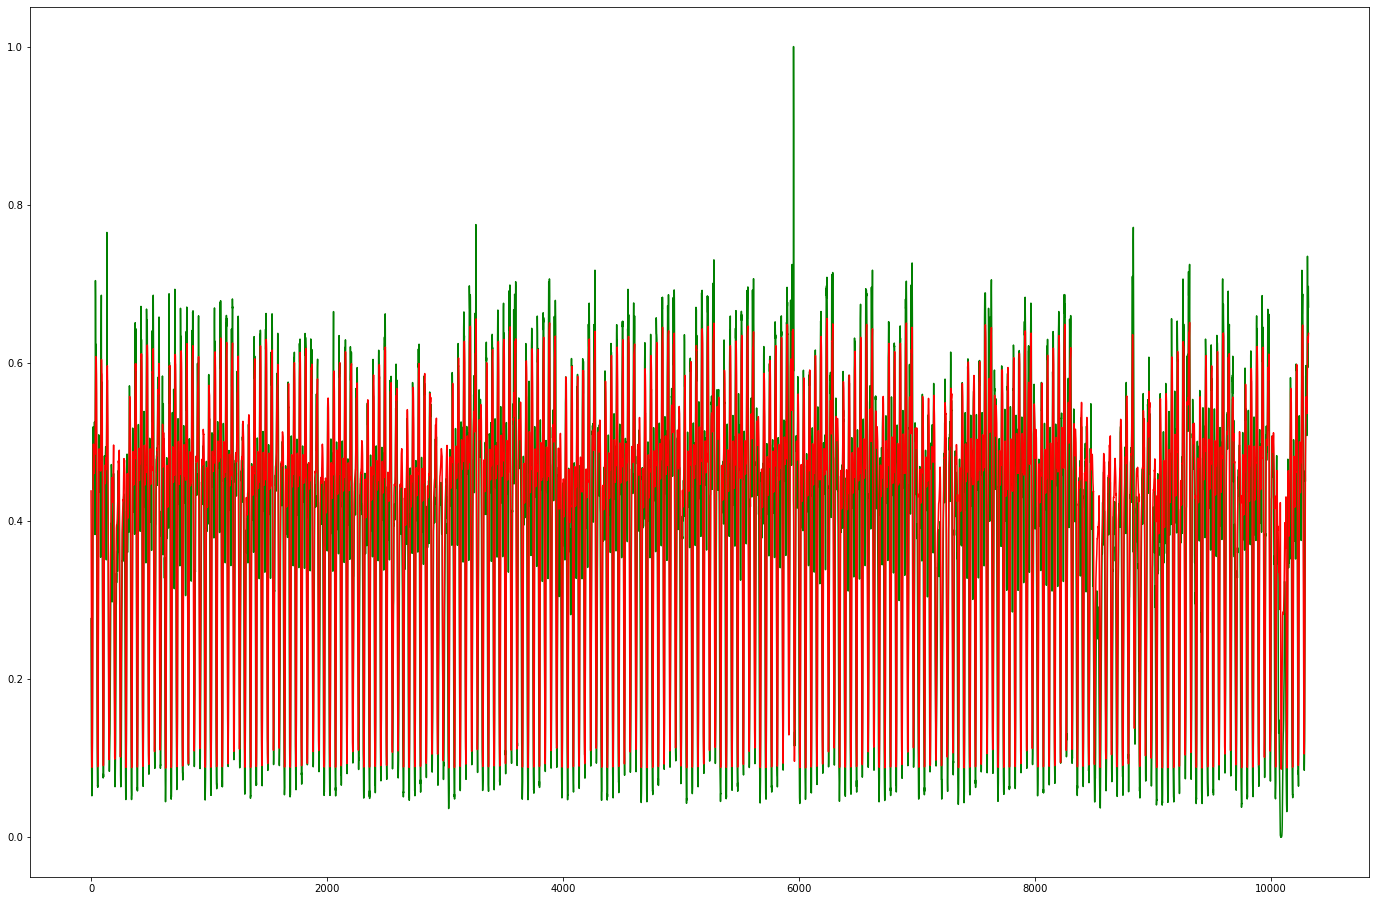

In [39]:
plt.figure(figsize=(24, 16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color = 'red')

In [40]:
z = zip(dist >= threshold, dist)
y_label = []
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)

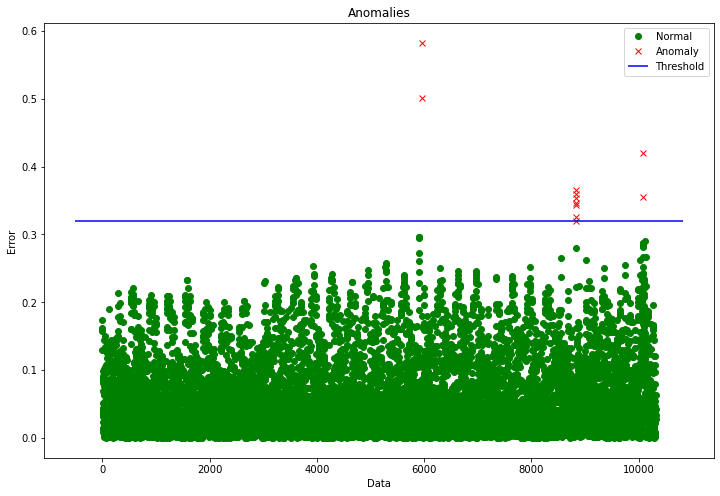

In [41]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

In [42]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation':df['value'],
                   'error':error, 'anomaly':y_label})
adf.head()

,Datetime,observation,error,anomaly
0,2014-07-01 00:00:00,10844,0.161503,0
1,2014-07-01 00:30:00,8127,0.174237,0
2,2014-07-01 01:00:00,6210,0.157255,0
3,2014-07-01 01:30:00,4656,0.129582,0
4,2014-07-01 02:00:00,3820,0.091514,0


Text(0.5, 1.0, 'Time Series of value by date time')

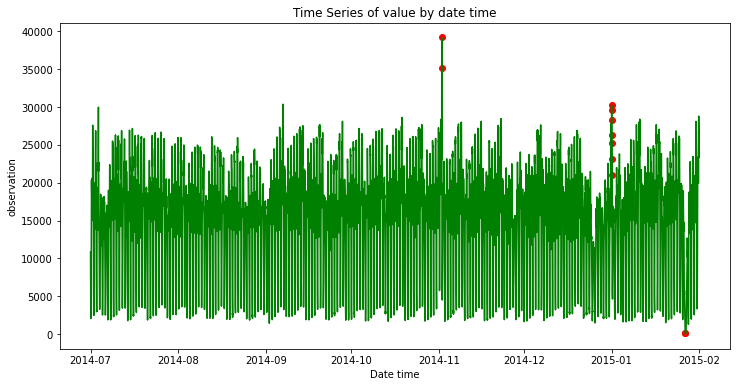

In [44]:
figure, axes = plt.subplots(figsize = (12, 6))
axes.plot(adf['Datetime'], adf['observation'], color = 'g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color = 'r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

In [45]:
dataFilePath = dataFilePaths[0]
df = pd.read_csv(filepath_or_buffer=dataFilePath)
print(df.shape[0])
df.head()

4032


,timestamp,value
0,2014-04-01 00:00:00,20.0
1,2014-04-01 00:05:00,20.0
2,2014-04-01 00:10:00,20.0
3,2014-04-01 00:15:00,20.0
4,2014-04-01 00:20:00,20.0


In [46]:
df['Datetime'] = pd.to_datetime(df['timestamp'])
# timestamp 형태의 자료를 시계열 형태의 자료로 바꿈
print(df.head())

             timestamp  value            Datetime
0  2014-04-01 00:00:00   20.0 2014-04-01 00:00:00
1  2014-04-01 00:05:00   20.0 2014-04-01 00:05:00
2  2014-04-01 00:10:00   20.0 2014-04-01 00:10:00
3  2014-04-01 00:15:00   20.0 2014-04-01 00:15:00
4  2014-04-01 00:20:00   20.0 2014-04-01 00:20:00


Text(0.5, 1.0, 'Time Series of value by date time')

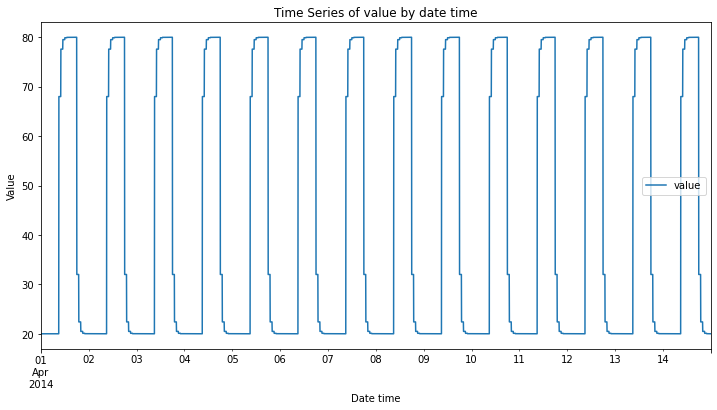

In [47]:
df.plot(x='Datetime', y = 'value', figsize = (12, 6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

<AxesSubplot:title={'center':'Before Scaling'}, xlabel='value', ylabel='Density'>

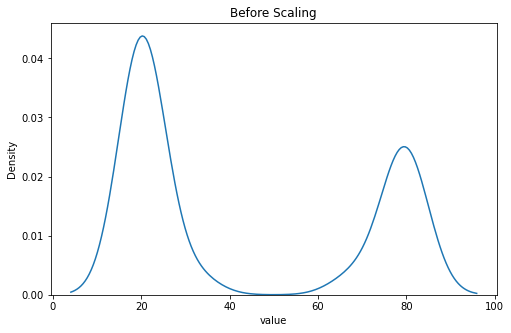

In [48]:
fig, (ax1) = plt.subplots(ncols=1, figsize = (8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

In [49]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])), columns=['value'])
print('Shape:', df.shape[0])
df.head()

Shape: 4032


,timestamp,value,Datetime,scaled_value
0,2014-04-01 00:00:00,20.0,2014-04-01 00:00:00,0.0
1,2014-04-01 00:05:00,20.0,2014-04-01 00:05:00,0.0
2,2014-04-01 00:10:00,20.0,2014-04-01 00:10:00,0.0
3,2014-04-01 00:15:00,20.0,2014-04-01 00:15:00,0.0
4,2014-04-01 00:20:00,20.0,2014-04-01 00:20:00,0.0


<AxesSubplot:title={'center':'After Scaling'}, xlabel='scaled_value', ylabel='Density'>

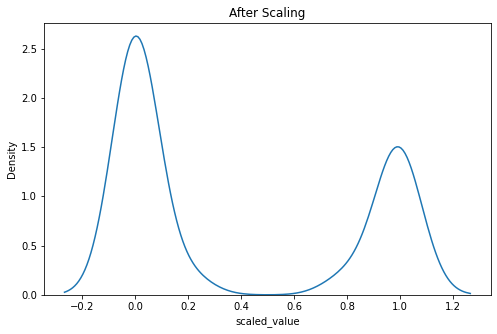

In [50]:
fig, (ax1) = plt.subplots(ncols=1, figsize = (8,5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

In [51]:
time_steps = 24*12
# 5분 단위로 데이터를 기록 하였으므로, 24시간 단위의 학습을 위해선 24*12로 지정.
metric = 'mean_absolute_error'

In [52]:
model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape = (time_steps, 1), return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss = 'mean_absolute_error', metrics=[metric])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 288, 32)           4352      
                                                                 
 dense_1 (Dense)             (None, 288, 1)            33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [53]:
sequence = np.array(df['scaled_value'])
print(sequence)

samples = len(sequence)
# 전체 데이터의 개수
trim = samples % time_steps
# 몫의 개수 설정
subsequences = int(samples/time_steps)
# 전체 sequence 에서 subsequence 의 개수 구하기
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
# 3차원 배열 형태로 조정
print(sequence_trimmed.shape)

[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 6.39999994e-05
 6.39999994e-05 6.39999994e-05]
4032 14
(14, 288, 1)


In [54]:
training_dataset = sequence_trimmed
print('training_dataset:', training_dataset.shape)

training_dataset: (14, 288, 1)


In [55]:
model.fit(x=training_dataset, y=training_dataset, batch_size=batch_size,
         epochs=epochs, validation_data=(training_dataset, training_dataset))

Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.4886 - mean_absolute_error: 0.4886 - val_loss: 0.4847 - val_mean_absolute_error: 0.4847
Epoch 2/20
1/1 [==============================] - 0s 82ms/step - loss: 0.4847 - mean_absolute_error: 0.4847 - val_loss: 0.4810 - val_mean_absolute_error: 0.4810
Epoch 3/20
1/1 [==============================] - 0s 81ms/step - loss: 0.4810 - mean_absolute_error: 0.4810 - val_loss: 0.4772 - val_mean_absolute_error: 0.4772
Epoch 4/20
1/1 [==============================] - 0s 83ms/step - loss: 0.4772 - mean_absolute_error: 0.4772 - val_loss: 0.4734 - val_mean_absolute_error: 0.4734
Epoch 5/20
1/1 [==============================] - 0s 88ms/step - loss: 0.4734 - mean_absolute_error: 0.4734 - val_loss: 0.4697 - val_mean_absolute_error: 0.4697
Epoch 6/20
1/1 [==============================] - 0s 91ms/step - loss: 0.4697 - mean_absolute_error: 0.4697 - val_loss: 0.4659 - val_mean_absolute_error: 0.4659
Epoch 7/20
1/1 [====================

In [56]:
print(samples, subsequences)

4032 14


testing_dataset: (14, 288, 1)
testing_pred: (14, 288, 1)
testing_dataset: (4032, 1)
testing_pred: (4032, 1)
(4032, 1)
Testing RMSE: 0.407
(4032,)
4027
0.4868814945220947


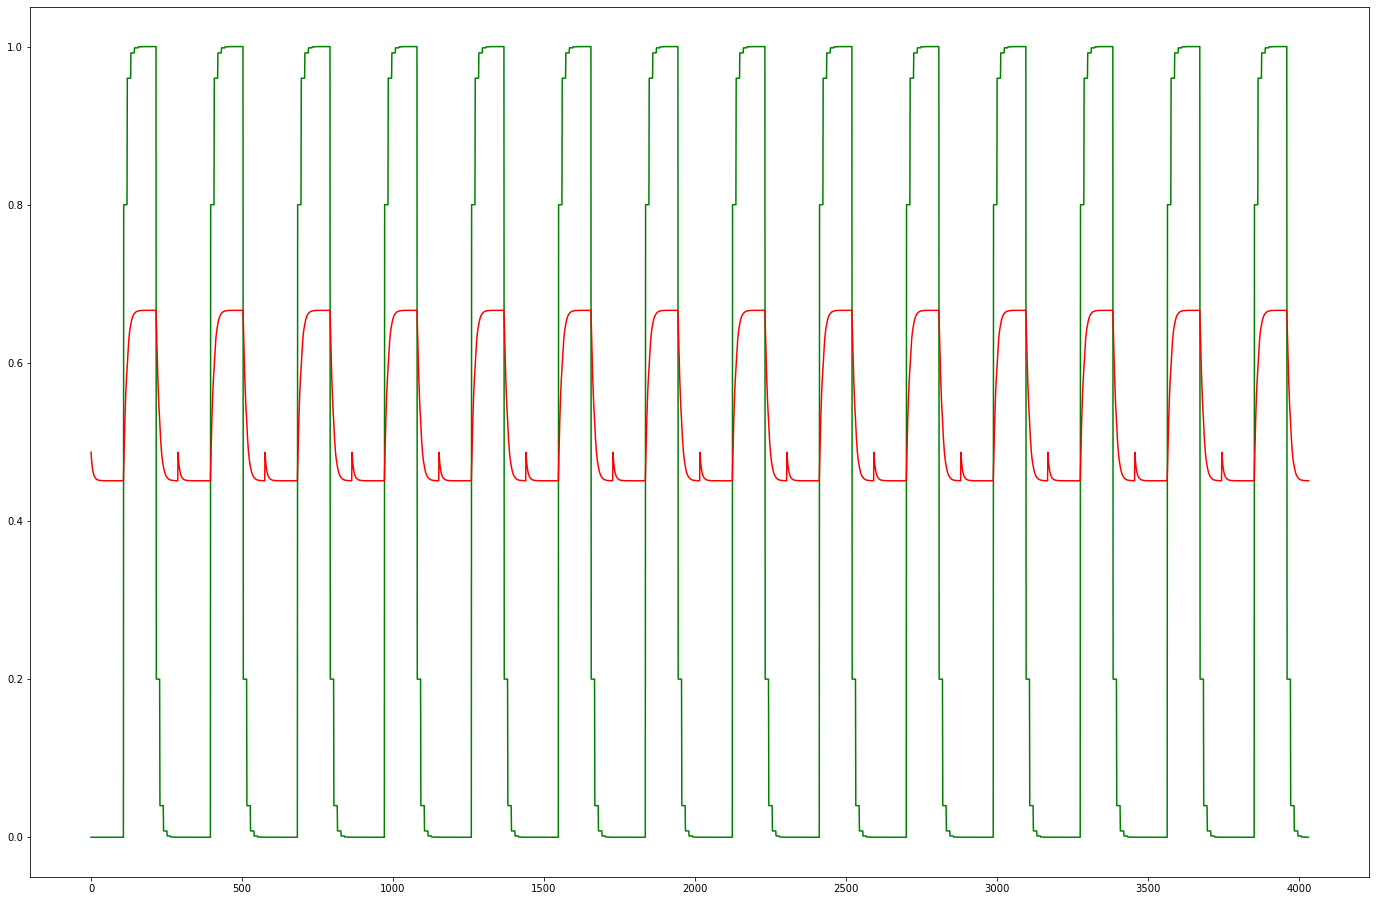

In [57]:
testing_dataset = sequence_trimmed
print('testing_dataset:', testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print('testing_pred:', testing_pred.shape)

testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print('testing_dataset:', testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print('testing_pred:', testing_pred.shape)

errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)

rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Testing RMSE: %.3f' % rmse)

dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores = dist.copy()
print(scores.shape)

scores.sort()
cutoff = int(0.999*len(scores))
print(cutoff)

threshold = scores[cutoff]
print(threshold)

plt.figure(figsize=(24, 16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color = 'red')

In [58]:
z = zip(dist >= threshold, dist)
y_label = []
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)

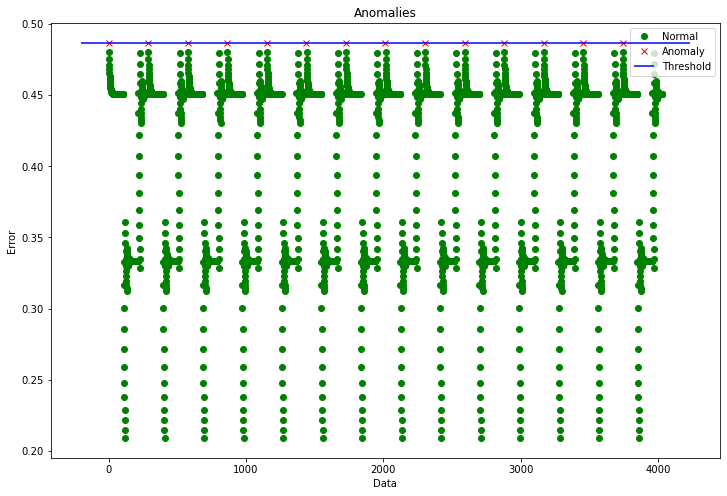

In [59]:
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

In [60]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation':df['value'],
                   'error':error, 'anomaly':y_label})
adf.head()

,Datetime,observation,error,anomaly
0,2014-04-01 00:00:00,20.0,0.486881,1
1,2014-04-01 00:05:00,20.0,0.480528,0
2,2014-04-01 00:10:00,20.0,0.475481,0
3,2014-04-01 00:15:00,20.0,0.471422,0
4,2014-04-01 00:20:00,20.0,0.468124,0


Text(0.5, 1.0, 'Time Series of value by date time')

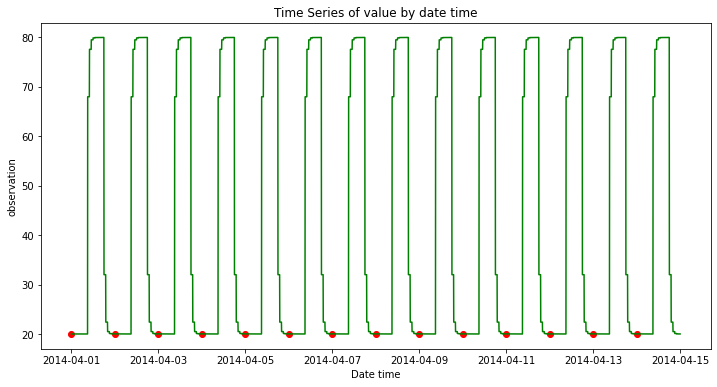

In [61]:
figure, axes = plt.subplots(figsize = (12, 6))
axes.plot(adf['Datetime'], adf['observation'], color = 'g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color = 'r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

In [62]:
dataFilePath = dataFilePaths[1]
df = pd.read_csv(filepath_or_buffer=dataFilePath)
print(df.shape[0])
df.head()

4032


,timestamp,value
0,2014-04-01 00:00:00,21.598011
1,2014-04-01 00:05:00,19.321392
2,2014-04-01 00:10:00,21.399938
3,2014-04-01 00:15:00,18.373916
4,2014-04-01 00:20:00,18.167499


In [63]:
df['Datetime'] = pd.to_datetime(df['timestamp'])
# timestamp 형태의 자료를 시계열 형태의 자료로 바꿈
print(df.head())

             timestamp      value            Datetime
0  2014-04-01 00:00:00  21.598011 2014-04-01 00:00:00
1  2014-04-01 00:05:00  19.321392 2014-04-01 00:05:00
2  2014-04-01 00:10:00  21.399938 2014-04-01 00:10:00
3  2014-04-01 00:15:00  18.373916 2014-04-01 00:15:00
4  2014-04-01 00:20:00  18.167499 2014-04-01 00:20:00


Text(0.5, 1.0, 'Time Series of value by date time')

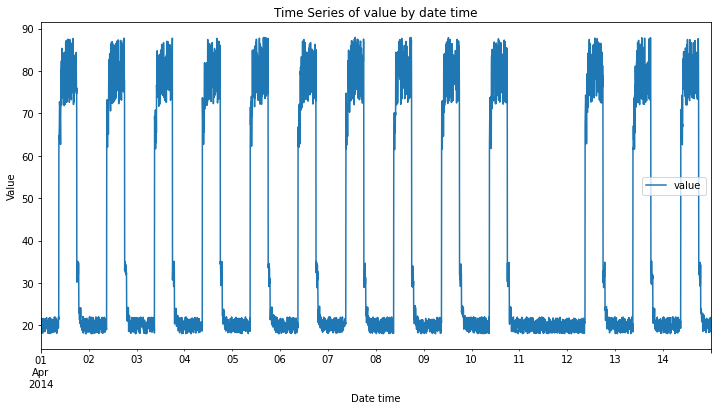

In [64]:
df.plot(x='Datetime', y = 'value', figsize = (12, 6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

<AxesSubplot:title={'center':'Before Scaling'}, xlabel='value', ylabel='Density'>

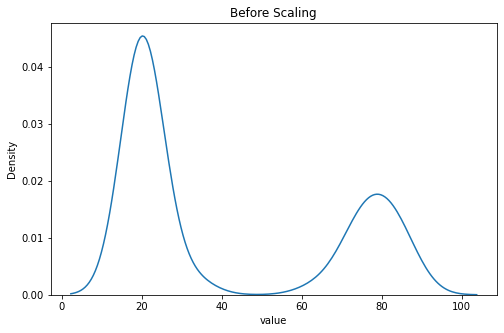

In [65]:
fig, (ax1) = plt.subplots(ncols=1, figsize = (8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])), columns=['value'])
print('Shape:', df.shape[0])
df.head()

Shape: 4032


,timestamp,value,Datetime,scaled_value
0,2014-04-01 00:00:00,21.598011,2014-04-01 00:00:00,0.051413
1,2014-04-01 00:05:00,19.321392,2014-04-01 00:05:00,0.018877
2,2014-04-01 00:10:00,21.399938,2014-04-01 00:10:00,0.048582
3,2014-04-01 00:15:00,18.373916,2014-04-01 00:15:00,0.005337
4,2014-04-01 00:20:00,18.167499,2014-04-01 00:20:00,0.002387


In [67]:
time_steps = 24*12
# 5분 단위로 데이터를 기록 하였으므로, 24시간 단위의 학습을 위해선 24*12로 지정.
metric = 'mean_absolute_error'

In [68]:
model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape = (time_steps, 1), return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss = 'mean_absolute_error', metrics=[metric])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 288, 32)           4352      
                                                                 
 dense_2 (Dense)             (None, 288, 1)            33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [69]:
sequence = np.array(df['scaled_value'])
print(sequence)

samples = len(sequence)
# 전체 데이터의 개수
trim = samples % time_steps
# 몫의 개수 설정
subsequences = int(samples/time_steps)
# 전체 sequence 에서 subsequence 의 개수 구하기
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
# 3차원 배열 형태로 조정
print(sequence_trimmed.shape)

[0.05141298 0.01887721 0.04858226 ... 0.04892265 0.0550305  0.01384229]
4032 14
(14, 288, 1)


In [70]:
training_dataset = sequence_trimmed
print('training_dataset:', training_dataset.shape)

model.fit(x=training_dataset, y=training_dataset, batch_size=batch_size,
         epochs=epochs, validation_data=(training_dataset, training_dataset))

training_dataset: (14, 288, 1)
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 0.4344 - mean_absolute_error: 0.4344 - val_loss: 0.4312 - val_mean_absolute_error: 0.4312
Epoch 2/20
1/1 [==============================] - 0s 81ms/step - loss: 0.4312 - mean_absolute_error: 0.4312 - val_loss: 0.4280 - val_mean_absolute_error: 0.4280
Epoch 3/20
1/1 [==============================] - 0s 90ms/step - loss: 0.4280 - mean_absolute_error: 0.4280 - val_loss: 0.4249 - val_mean_absolute_error: 0.4249
Epoch 4/20
1/1 [==============================] - 0s 87ms/step - loss: 0.4249 - mean_absolute_error: 0.4249 - val_loss: 0.4218 - val_mean_absolute_error: 0.4218
Epoch 5/20
1/1 [==============================] - 0s 83ms/step - loss: 0.4218 - mean_absolute_error: 0.4218 - val_loss: 0.4186 - val_mean_absolute_error: 0.4186
Epoch 6/20
1/1 [==============================] - 0s 93ms/step - loss: 0.4186 - mean_absolute_error: 0.4186 - val_loss: 0.4155 - val_mean_absolute_error: 0.4155
Epoch

testing_dataset: (14, 288, 1)
testing_pred: (14, 288, 1)
testing_dataset: (4032, 1)
testing_pred: (4032, 1)
(4032, 1)
Testing RMSE: 0.373
(4032,)
4027
0.4892198151257772


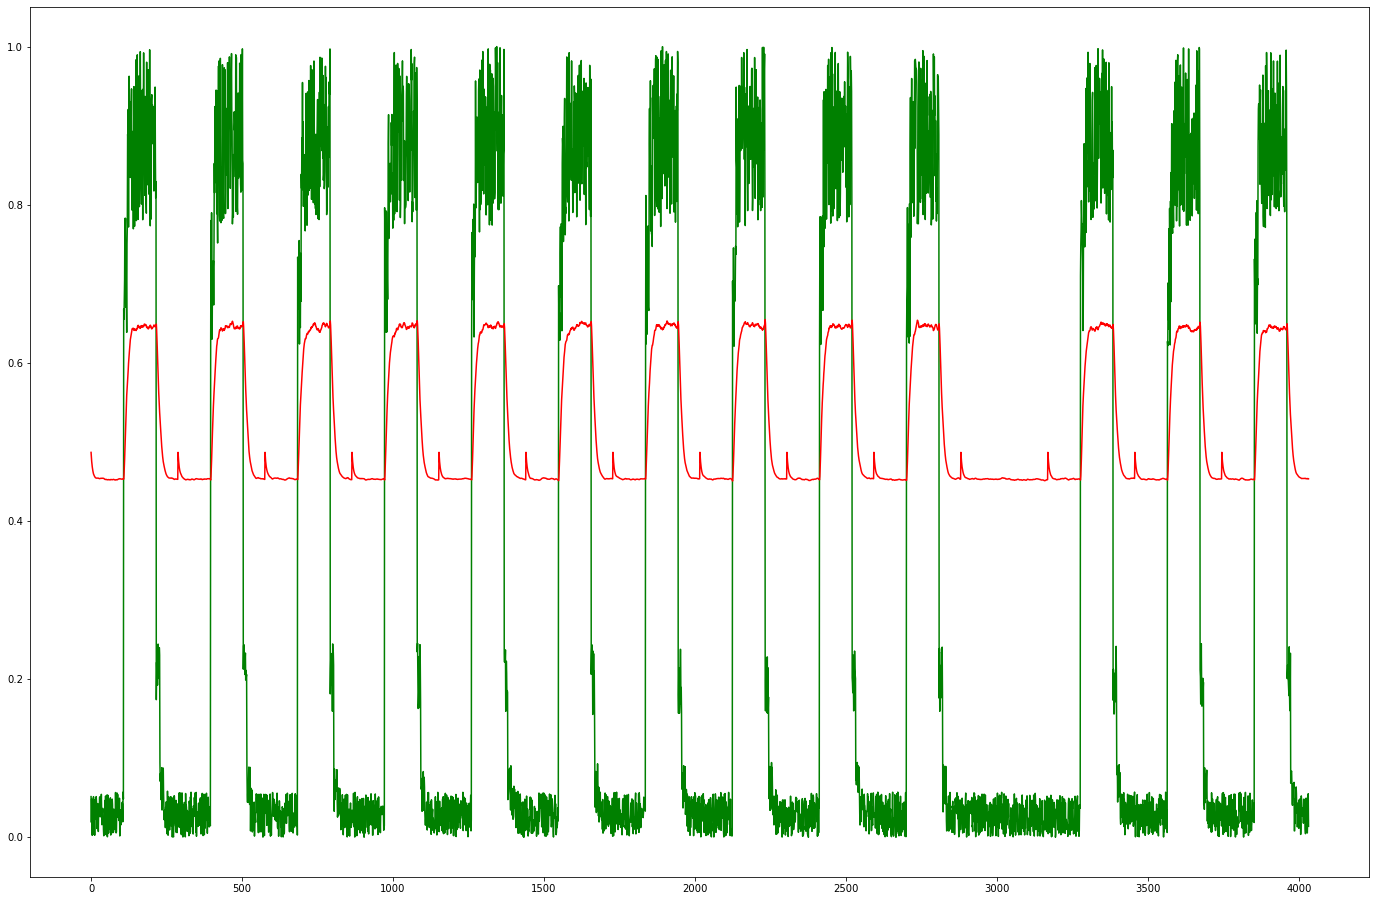

In [71]:
testing_dataset = sequence_trimmed
print('testing_dataset:', testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print('testing_pred:', testing_pred.shape)

testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print('testing_dataset:', testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print('testing_pred:', testing_pred.shape)

errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)

rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Testing RMSE: %.3f' % rmse)

dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores = dist.copy()
print(scores.shape)

scores.sort()
cutoff = int(0.999*len(scores))
print(cutoff)

threshold = scores[cutoff]
print(threshold)

plt.figure(figsize=(24, 16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color = 'red')

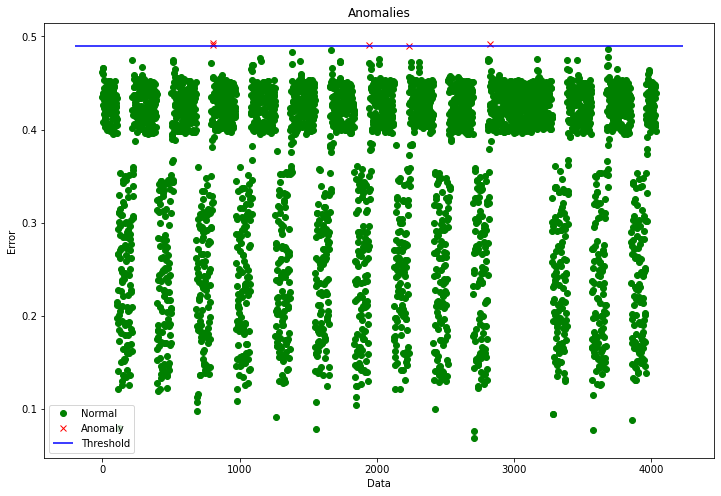

In [72]:
z = zip(dist >= threshold, dist)
y_label = []
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
    
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

Text(0.5, 1.0, 'Time Series of value by date time')

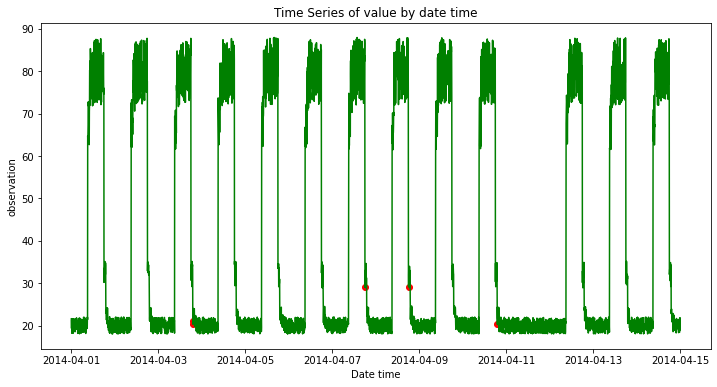

In [73]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation':df['value'],
                   'error':error, 'anomaly':y_label})
adf.head()

figure, axes = plt.subplots(figsize = (12, 6))
axes.plot(adf['Datetime'], adf['observation'], color = 'g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color = 'r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

4032
             timestamp      value            Datetime
0  2014-04-01 00:00:00  18.090486 2014-04-01 00:00:00
1  2014-04-01 00:05:00  20.359843 2014-04-01 00:05:00
2  2014-04-01 00:10:00  21.105470 2014-04-01 00:10:00
3  2014-04-01 00:15:00  21.151585 2014-04-01 00:15:00
4  2014-04-01 00:20:00  18.137141 2014-04-01 00:20:00
Shape: 4032
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 288, 32)           4352      
                                                                 
 dense_3 (Dense)             (None, 288, 1)            33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
[0.00126358 0.03368466 0.04433703 ... 0.02275332 0.02522671 0.03538923]
4032 14
(14, 288, 1)
training_datas

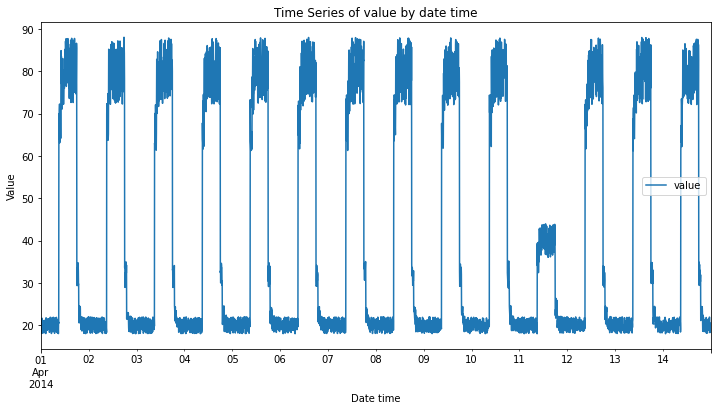

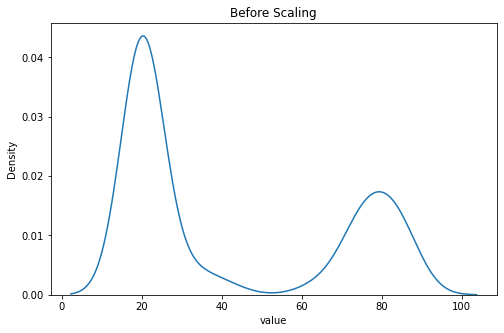

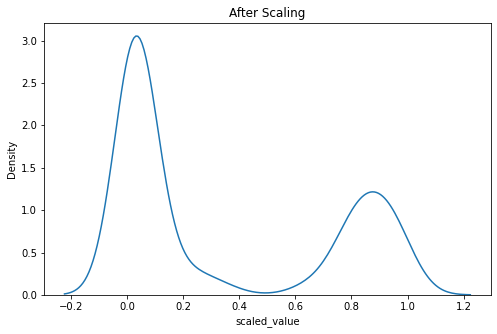

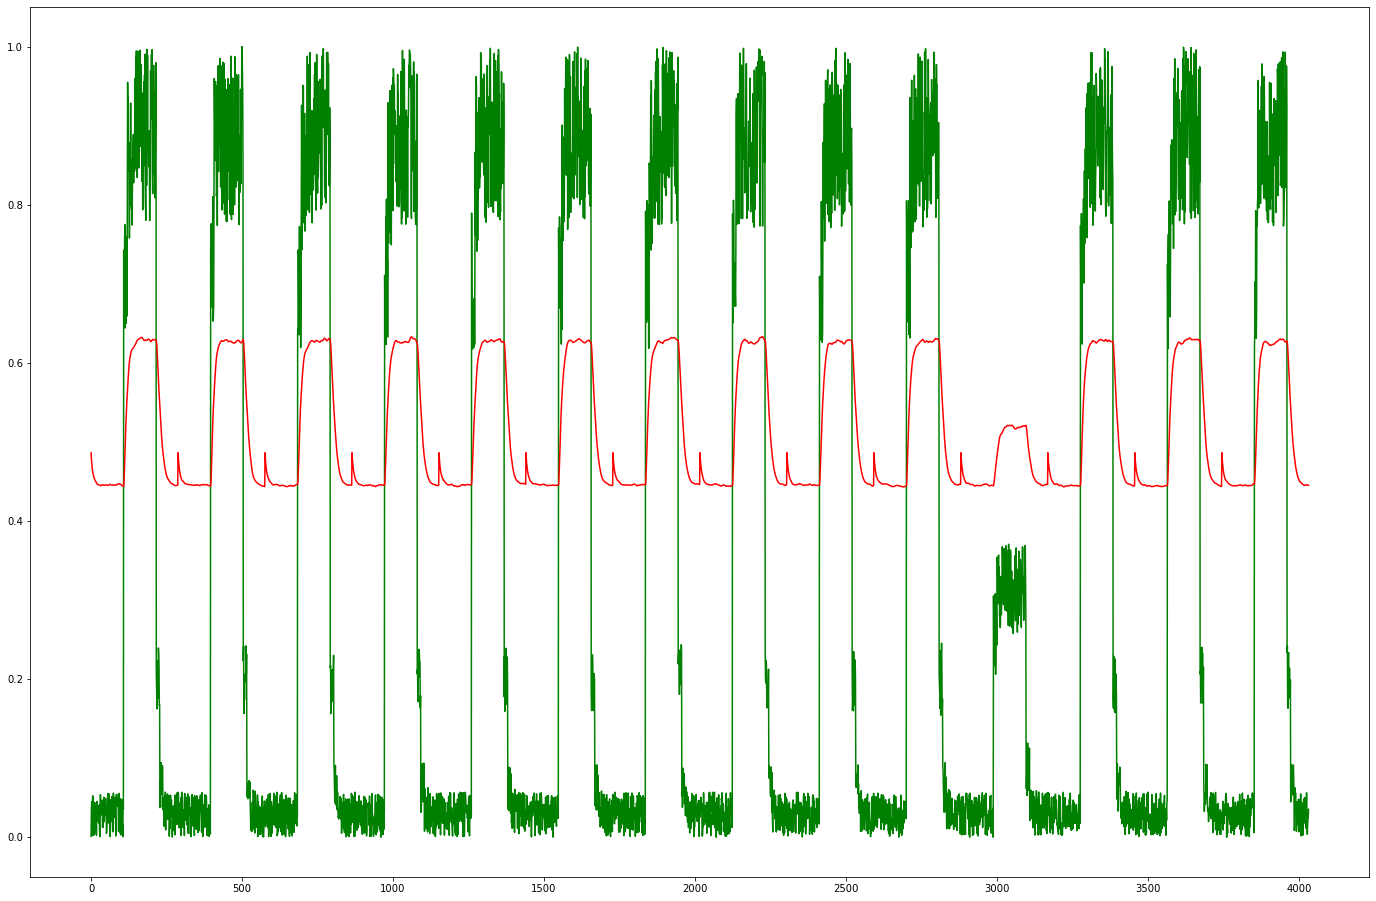

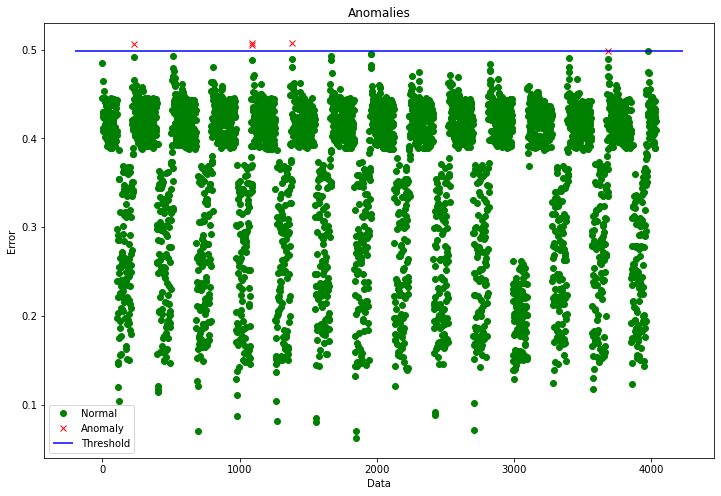

In [74]:
dataFilePath = dataFilePaths[2]
df = pd.read_csv(filepath_or_buffer=dataFilePath)
print(df.shape[0])
df.head()

df['Datetime'] = pd.to_datetime(df['timestamp'])
# timestamp 형태의 자료를 시계열 형태의 자료로 바꿈
print(df.head())

df.plot(x='Datetime', y = 'value', figsize = (12, 6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

fig, (ax1) = plt.subplots(ncols=1, figsize = (8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])), columns=['value'])
print('Shape:', df.shape[0])
df.head()

fig, (ax1) = plt.subplots(ncols=1, figsize = (8,5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

time_steps = 24*12
# 5분 단위로 데이터를 기록 하였으므로, 24시간 단위의 학습을 위해선 24*12로 지정.
metric = 'mean_absolute_error'

model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape = (time_steps, 1), return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss = 'mean_absolute_error', metrics=[metric])
model.summary()

sequence = np.array(df['scaled_value'])
print(sequence)

samples = len(sequence)
# 전체 데이터의 개수
trim = samples % time_steps
# 몫의 개수 설정
subsequences = int(samples/time_steps)
# 전체 sequence 에서 subsequence 의 개수 구하기
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
# 3차원 배열 형태로 조정
print(sequence_trimmed.shape)

training_dataset = sequence_trimmed
print('training_dataset:', training_dataset.shape)

model.fit(x=training_dataset, y=training_dataset, batch_size=batch_size,
         epochs=epochs, validation_data=(training_dataset, training_dataset))

testing_dataset = sequence_trimmed
print('testing_dataset:', testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print('testing_pred:', testing_pred.shape)

testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print('testing_dataset:', testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print('testing_pred:', testing_pred.shape)

errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)

rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Testing RMSE: %.3f' % rmse)

dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores = dist.copy()
print(scores.shape)

scores.sort()
cutoff = int(0.999*len(scores))
print(cutoff)

threshold = scores[cutoff]
print(threshold)

plt.figure(figsize=(24, 16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color = 'red')

z = zip(dist >= threshold, dist)
y_label = []
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
    
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

Text(0.5, 1.0, 'Time Series of value by date time')

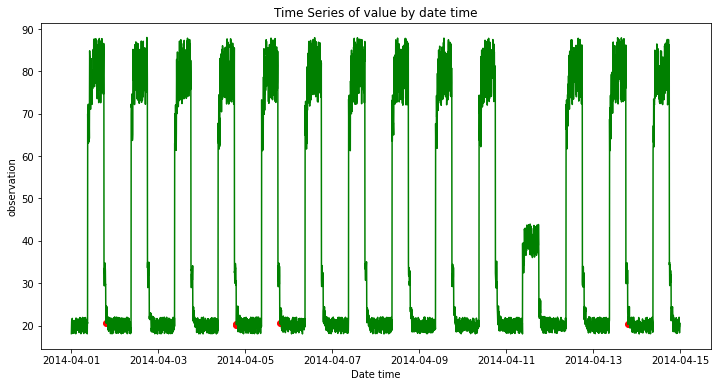

In [75]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation':df['value'],
                   'error':error, 'anomaly':y_label})
adf.head()

figure, axes = plt.subplots(figsize = (12, 6))
axes.plot(adf['Datetime'], adf['observation'], color = 'g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color = 'r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

4032
             timestamp  value            Datetime
0  2014-02-14 14:30:00  0.132 2014-02-14 14:30:00
1  2014-02-14 14:35:00  0.134 2014-02-14 14:35:00
2  2014-02-14 14:40:00  0.134 2014-02-14 14:40:00
3  2014-02-14 14:45:00  0.134 2014-02-14 14:45:00
4  2014-02-14 14:50:00  0.134 2014-02-14 14:50:00
Shape: 4032
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 48, 32)            4352      
                                                                 
 dense_5 (Dense)             (None, 48, 1)             33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
[0.02897278 0.02985075 0.02985075 ... 0.02985075 0.02985075 0.02985075]
4032 84
(84, 48, 1)
training_dataset: (84, 48, 1)
Epoch 1/2

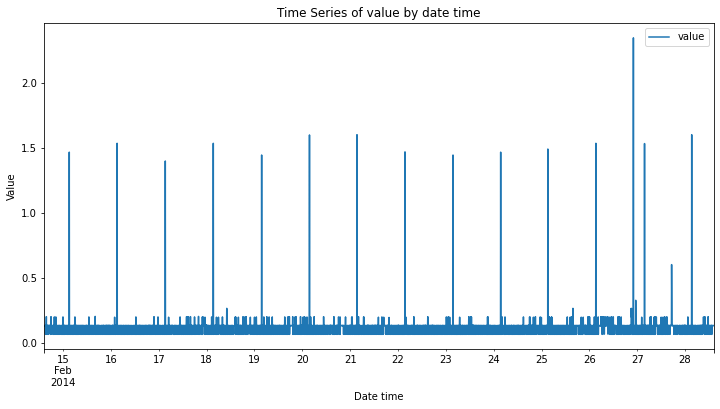

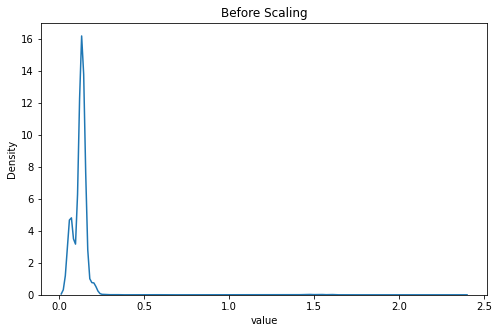

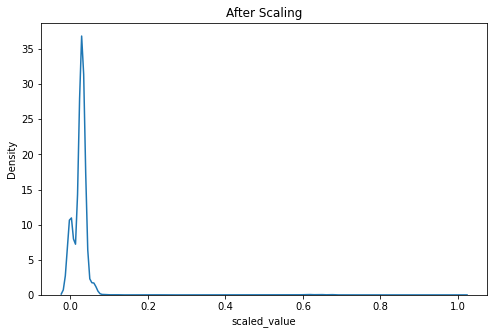

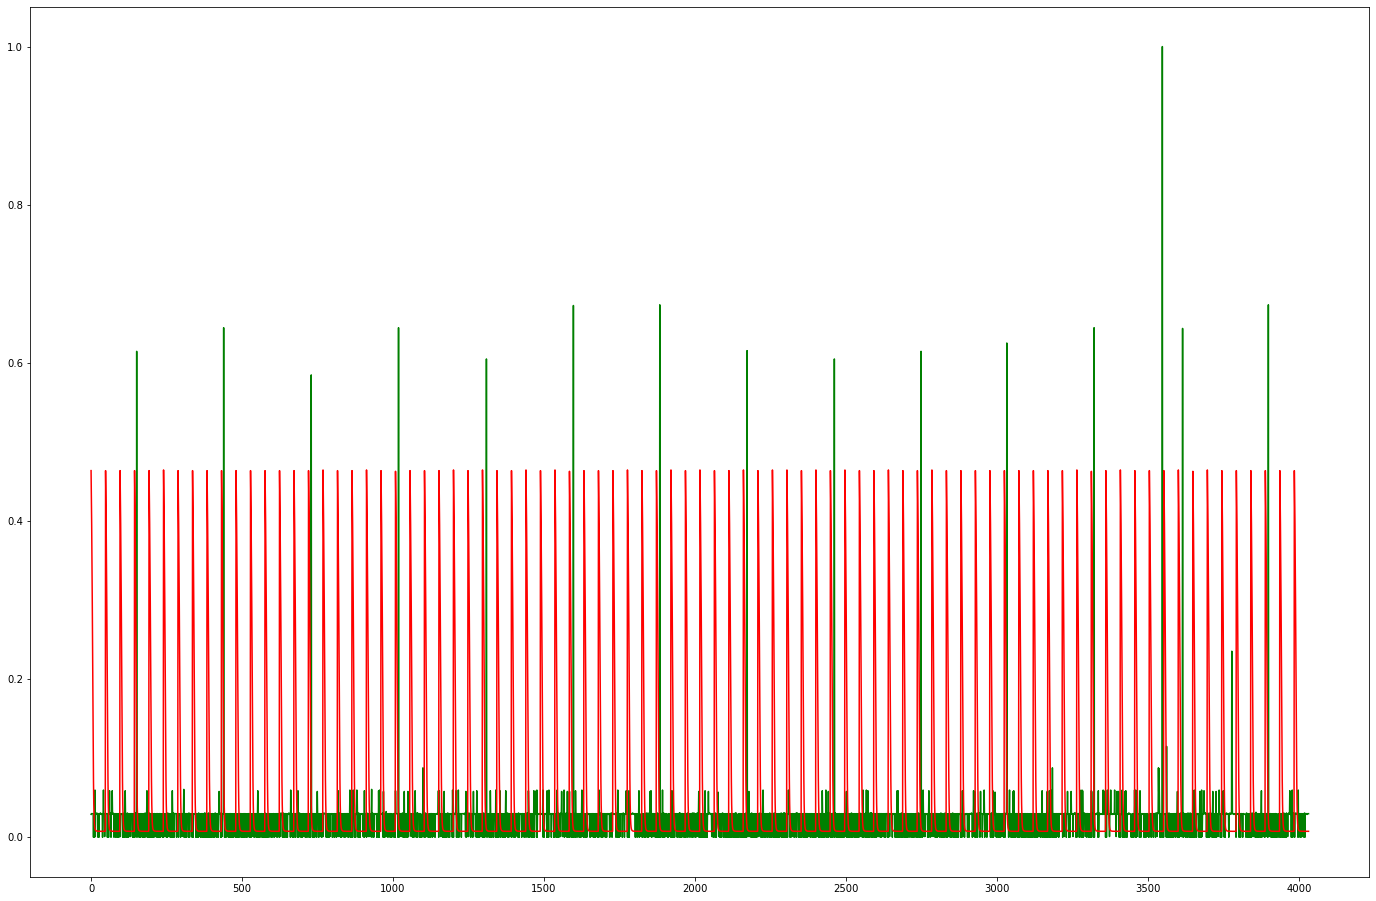

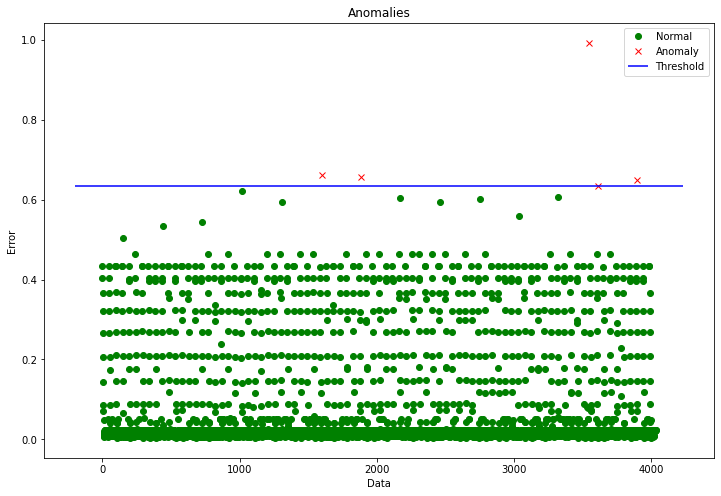

In [78]:
dataFilePath = dataFilePaths[8]
df = pd.read_csv(filepath_or_buffer=dataFilePath)
print(df.shape[0])
df.head()

df['Datetime'] = pd.to_datetime(df['timestamp'])
# timestamp 형태의 자료를 시계열 형태의 자료로 바꿈
print(df.head())

df.plot(x='Datetime', y = 'value', figsize = (12, 6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

fig, (ax1) = plt.subplots(ncols=1, figsize = (8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])), columns=['value'])
print('Shape:', df.shape[0])
df.head()

fig, (ax1) = plt.subplots(ncols=1, figsize = (8,5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

time_steps = 24*2
# 5분 단위로 데이터를 기록 하였으므로, 24시간 단위의 학습을 위해선 24*12로 지정.
metric = 'mean_absolute_error'

model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape = (time_steps, 1), return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss = 'mean_absolute_error', metrics=[metric])
model.summary()

sequence = np.array(df['scaled_value'])
print(sequence)

samples = len(sequence)
# 전체 데이터의 개수
trim = samples % time_steps
# 몫의 개수 설정
subsequences = int(samples/time_steps)
# 전체 sequence 에서 subsequence 의 개수 구하기
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
# 3차원 배열 형태로 조정
print(sequence_trimmed.shape)

training_dataset = sequence_trimmed
print('training_dataset:', training_dataset.shape)

model.fit(x=training_dataset, y=training_dataset, batch_size=batch_size,
         epochs=epochs, validation_data=(training_dataset, training_dataset))

testing_dataset = sequence_trimmed
print('testing_dataset:', testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print('testing_pred:', testing_pred.shape)

testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print('testing_dataset:', testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print('testing_pred:', testing_pred.shape)

errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)

rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Testing RMSE: %.3f' % rmse)

dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores = dist.copy()
print(scores.shape)

scores.sort()
cutoff = int(0.999*len(scores))
print(cutoff)

threshold = scores[cutoff]
print(threshold)

plt.figure(figsize=(24, 16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color = 'red')

z = zip(dist >= threshold, dist)
y_label = []
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
    
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

Text(0.5, 1.0, 'Time Series of value by date time')

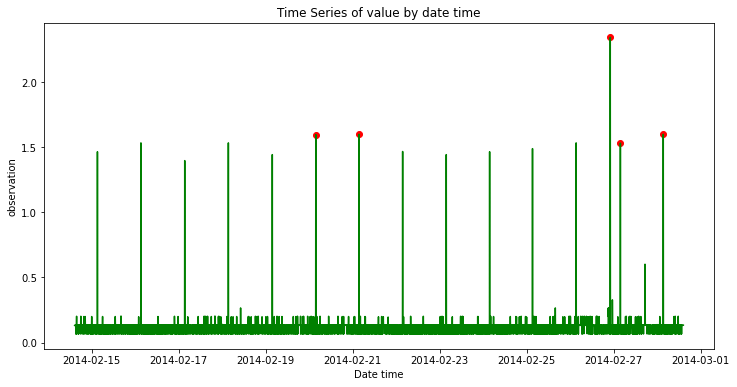

In [79]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation':df['value'],
                   'error':error, 'anomaly':y_label})
adf.head()

figure, axes = plt.subplots(figsize = (12, 6))
axes.plot(adf['Datetime'], adf['observation'], color = 'g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color = 'r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')

7267
             timestamp      value            Datetime
0  2013-07-04 00:00:00  69.880835 2013-07-04 00:00:00
1  2013-07-04 01:00:00  71.220227 2013-07-04 01:00:00
2  2013-07-04 02:00:00  70.877805 2013-07-04 02:00:00
3  2013-07-04 03:00:00  68.959400 2013-07-04 03:00:00
4  2013-07-04 04:00:00  69.283551 2013-07-04 04:00:00
Shape: 7248
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 24, 32)            4352      
                                                                 
 dense_9 (Dense)             (None, 24, 1)             33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
[0.43186209 0.47842565 0.46652145 ... 0.48197899 0.48781215 0.49904975]
7248 302
(302, 24, 1)
training_data

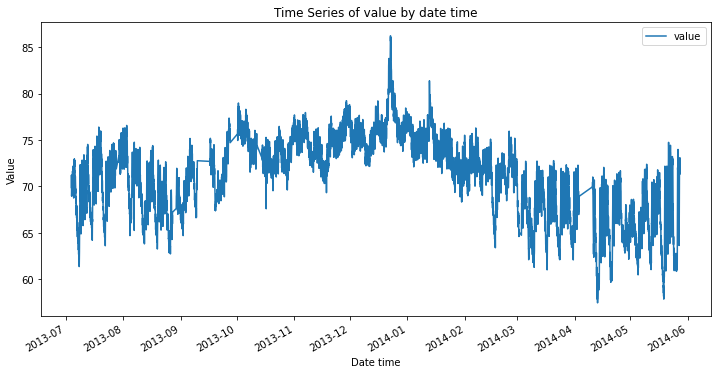

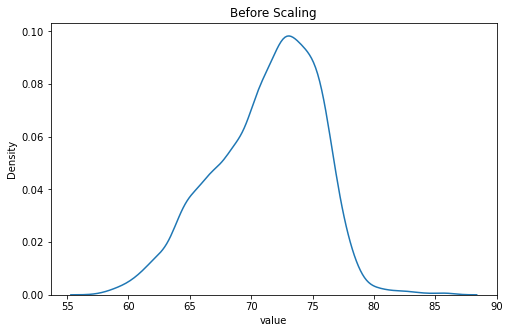

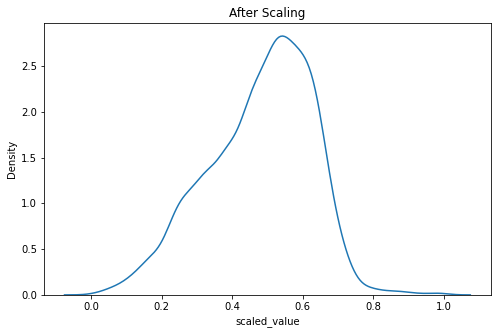

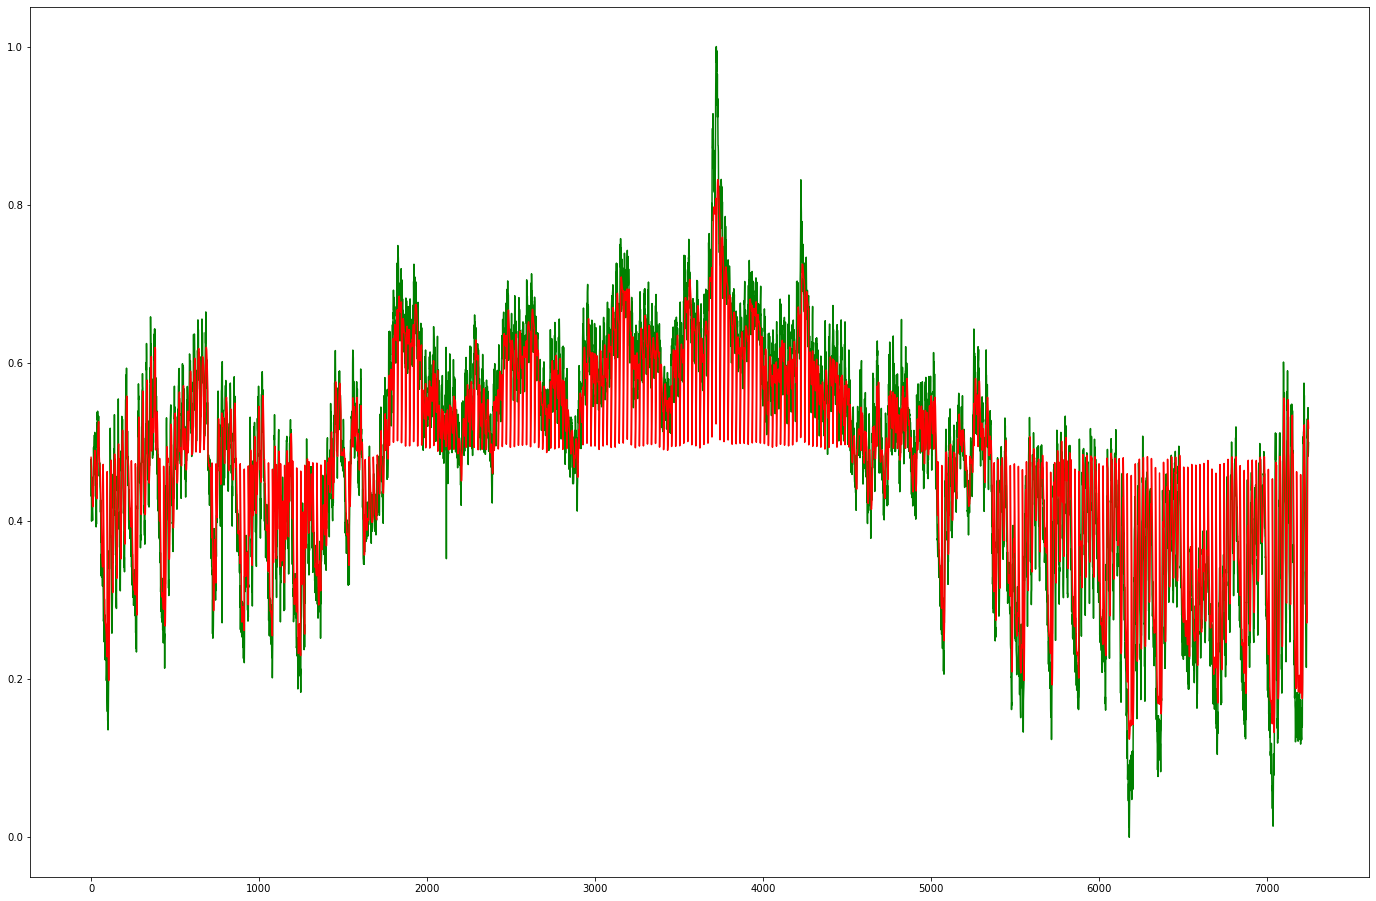

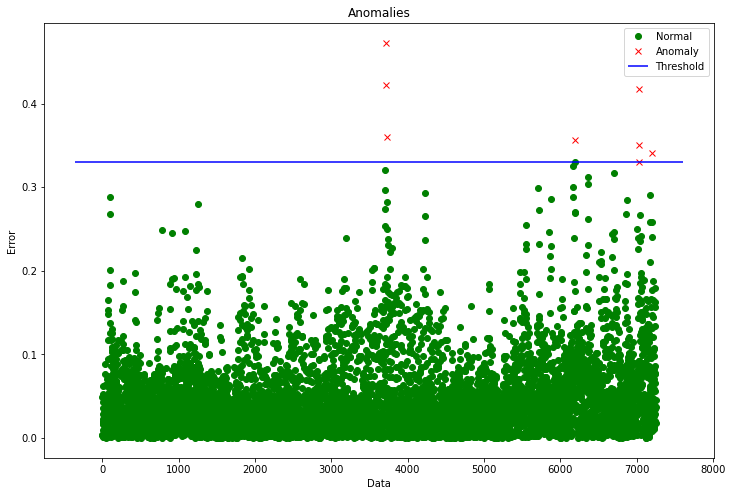

In [94]:
dataFilePath = dataFilePaths[6]
df = pd.read_csv(filepath_or_buffer=dataFilePath)
print(df.shape[0])
df.head()

df['Datetime'] = pd.to_datetime(df['timestamp'])
df = df[0:7248]
# 24의 배수로 데이터 날려줌
# timestamp 형태의 자료를 시계열 형태의 자료로 바꿈
print(df.head())

df.plot(x='Datetime', y = 'value', figsize = (12, 6))
plt.xlabel('Date time')
plt.ylabel('Value')
plt.title('Time Series of value by date time')

fig, (ax1) = plt.subplots(ncols=1, figsize = (8, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(df['value'], ax=ax1)

scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_value'] = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['value'])), columns=['value'])
print('Shape:', df.shape[0])
df.head()

fig, (ax1) = plt.subplots(ncols=1, figsize = (8,5))
ax1.set_title('After Scaling')
sns.kdeplot(df['scaled_value'], ax=ax1)

time_steps = 24

metric = 'mean_absolute_error'

model = Sequential()
model.add(LSTM(units=32, activation='tanh', input_shape = (time_steps, 1), return_sequences=True))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss = 'mean_absolute_error', metrics=[metric])
model.summary()

sequence = np.array(df['scaled_value'])
print(sequence)

samples = len(sequence)
# 전체 데이터의 개수
trim = samples % time_steps
# 몫의 개수 설정
subsequences = int(samples/time_steps)
# 전체 sequence 에서 subsequence 의 개수 구하기
sequence_trimmed = sequence[:samples - trim]

print(samples, subsequences)
sequence_trimmed.shape = (subsequences, time_steps, 1)
# 3차원 배열 형태로 조정
print(sequence_trimmed.shape)

training_dataset = sequence_trimmed
print('training_dataset:', training_dataset.shape)

model.fit(x=training_dataset, y=training_dataset, batch_size=batch_size,
         epochs=epochs, validation_data=(training_dataset, training_dataset))

testing_dataset = sequence_trimmed
print('testing_dataset:', testing_dataset.shape)

testing_pred = model.predict(x=testing_dataset)
print('testing_pred:', testing_pred.shape)

testing_dataset = testing_dataset.reshape((testing_dataset.shape[0]*testing_dataset.shape[1]), testing_dataset.shape[2])
print('testing_dataset:', testing_dataset.shape)

testing_pred = testing_pred.reshape((testing_pred.shape[0]*testing_pred.shape[1]), testing_pred.shape[2])
print('testing_pred:', testing_pred.shape)

errorsDF = testing_dataset - testing_pred
print(errorsDF.shape)

rmse = math.sqrt(mean_squared_error(testing_dataset, testing_pred))
print('Testing RMSE: %.3f' % rmse)

dist = np.linalg.norm(testing_dataset - testing_pred, axis=-1)

scores = dist.copy()
print(scores.shape)

scores.sort()
cutoff = int(0.999*len(scores))
print(cutoff)

threshold = scores[cutoff]
print(threshold)

plt.figure(figsize=(24, 16))
plt.plot(testing_dataset, color='green')
plt.plot(testing_pred, color = 'red')

z = zip(dist >= threshold, dist)
y_label = []
error = []
for idx, (is_anomaly, dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(dist)
    
viz = Visualization()
viz.draw_anomaly(y_label, error, threshold)

Text(0.5, 1.0, 'Time Series of value by date time')

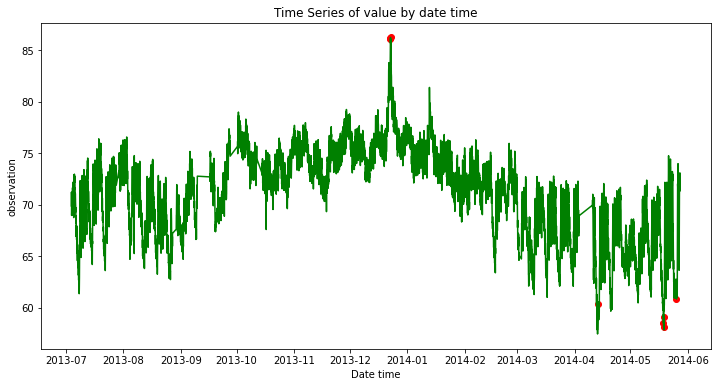

In [95]:
adf = pd.DataFrame({'Datetime': df['Datetime'], 'observation':df['value'],
                   'error':error, 'anomaly':y_label})
adf.head()

figure, axes = plt.subplots(figsize = (12, 6))
axes.plot(adf['Datetime'], adf['observation'], color = 'g')
anomaliesDF = adf.query('anomaly == 1')
axes.scatter(anomaliesDF['Datetime'].values, anomaliesDF['observation'], color = 'r')
plt.xlabel('Date time')
plt.ylabel('observation')
plt.title('Time Series of value by date time')